In [1]:
import csv
import os
import numpy as np
import pickle
import seaborn as sns
import datetime as d
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
NEWS_CHANNELS = ['IndianExpress','TimesNow','thewire_in','the_hindu','ThePrintIndia','timesofindia']
RELATIVE_PATH = './tweet_data/'

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sentimentAnalyzer = SentimentIntensityAnalyzer()

#### Looking at examples manually, I saw some examples related to corona virus where we see incorrect sentiment analysis. For example 'new record' for corona cases is being seen as positive sentiment. This and reason that most of the news around early 2020 months would be related to corona itself. Thus we only pick news tweets for year 2019.

In [4]:
example1 = "as of now  west bengal has reported  covid  cases  including  deaths"
example2 = "coronavirus numbers explained  daily increase touch a new record for the fourth time in one week"
score1 = sentimentAnalyzer.polarity_scores(example1)
score2 = sentimentAnalyzer.polarity_scores(example2)
print(example1, '-> score is', score1['compound'])
print(example2, '-> score is', score2['compound'])

as of now  west bengal has reported  covid  cases  including  deaths -> score is 0.0
coronavirus numbers explained  daily increase touch a new record for the fourth time in one week -> score is 0.3182


In [5]:
def epochToTime( epoch ):
    t = int( epoch )
    return d.datetime.fromtimestamp(t);

def getTweetsOfNewsChannels():
    tweets_data = {}
    for channel in NEWS_CHANNELS:
        data = []
        data_file = open( os.path.join(RELATIVE_PATH, channel + '_tweets.csv'), 'r')
        reader = csv.reader(data_file);
        next(reader)
        for row in reader:
            time = epochToTime(row[1])
            if time.year != 2019: # we only take for year 2019
                continue;
            data_row = {'id':row[0], 'time':time, 'tweet':row[2], 'mentions':row[3], 'replies_count':row[4],
                        'retweets_count':row[5], 'likes_count':row[6], 'hashtags':row[7] }
            data.append(data_row)
        tweets_data[ channel ] = data
    return tweets_data;

In [6]:
tweets_channel_mapping = getTweetsOfNewsChannels()

In [7]:
channels_unique_tweets = {}
for channel in NEWS_CHANNELS:
    unique_tweets= {}
    for tweet in tweets_channel_mapping[channel]:
        unique_tweets[tweet['tweet']] = 1
    channels_unique_tweets[ channel ] = list(unique_tweets.keys())

IndianExpress has 62363 total tweets and 60766 unique tweets
TimesNow has 108985 total tweets and 96037 unique tweets
thewire_in has 19543 total tweets and 19195 unique tweets
the_hindu has 32630 total tweets and 31414 unique tweets
ThePrintIndia has 28649 total tweets and 27464 unique tweets
timesofindia has 80758 total tweets and 75987 unique tweets


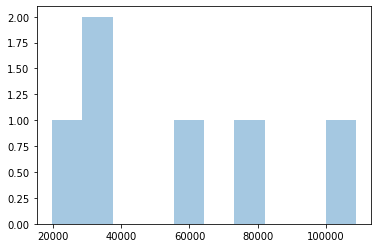

In [8]:
#1. How many tweets per news channel
for key in tweets_channel_mapping.keys():
    print(key,'has', len(tweets_channel_mapping[key]), 'total tweets and', len(channels_unique_tweets[key]), 'unique tweets')
tweet_counts = [ len(v) for v in tweets_channel_mapping.values() ]
sns.distplot(tweet_counts, bins=10, kde=False);

##### We see large differences in number of tweets different news sources...which makes analysis limited. Let's start with sentiment analysis...

In [9]:
def sentiment_analysis( sentiment_threshold ):
    for channel in channels_unique_tweets.keys():
        neg = 0
        pos = 0
        neu = 0
        for tweet in channels_unique_tweets[channel]:
            sentiment_a = sentimentAnalyzer.polarity_scores(tweet)['compound']
            if sentiment_a < -sentiment_threshold:
                neg = neg + 1
            elif sentiment_a > sentiment_threshold:
                pos = pos + 1
            else:
                neu = neu + 1
        total = len(channels_unique_tweets[channel])
        print( '%s -> negative(%3.2f%%), positive(%3.2f%%), neutral(%3.2f%%)' % (channel, neg*100/total, pos*100/total, neu*100/total))

In [10]:
print('Setting threshold as 0.05')
sentiment_analysis( 0.05 )

Setting threshold as 0.05
IndianExpress -> negative(36.99%), positive(30.53%), neutral(32.48%)
TimesNow -> negative(35.39%), positive(35.06%), neutral(29.54%)
thewire_in -> negative(45.08%), positive(37.56%), neutral(17.36%)
the_hindu -> negative(35.34%), positive(37.28%), neutral(27.38%)
ThePrintIndia -> negative(35.91%), positive(37.28%), neutral(26.81%)
timesofindia -> negative(31.47%), positive(33.62%), neutral(34.91%)


In [11]:
print('Setting threshold as 0.85')
sentiment_analysis( 0.85 )

Setting threshold as 0.85
IndianExpress -> negative(2.21%), positive(0.87%), neutral(96.92%)
TimesNow -> negative(2.55%), positive(0.95%), neutral(96.50%)
thewire_in -> negative(5.64%), positive(1.96%), neutral(92.40%)
the_hindu -> negative(2.94%), positive(1.38%), neutral(95.68%)
ThePrintIndia -> negative(1.48%), positive(0.69%), neutral(97.83%)
timesofindia -> negative(1.79%), positive(1.07%), neutral(97.14%)


##### We see that for smaller threshold, sentiment analysis shows almost equal division between positive, negative and neutral sentiment. If we increase the threshold very high to 0.85, we see a contrast in positive and negative news, with negative news being consistently more than the positive news!
##### Let's see now what are most used hashtags and mentions

In [12]:
def most_used( lmbd ):
    for channel in NEWS_CHANNELS:
        mapping = {}
        for x in tweets_channel_mapping[channel]:
            for ht in lmbd(x):
                if ht == '':
                    continue
                if ht in mapping.keys():
                    mapping[ht] = mapping[ht] + 1
                else:
                    mapping[ht] = 1
        z = [ [mapping[x],x] for x in mapping.keys() ]
        z.sort(reverse=True)
        print( channel, [ x[1] for x in z[0:10] ] )

In [13]:
print('Most used mentions ->')
most_used( lambda x : x['mentions'].split('@') )

Most used mentions ->
IndianExpress ['ieexplained', 'ieparenting', 'unnycartoonist', 'piyushgoyal', 'narendramodi', 'nishantshekhar1', 'rahulgandhi', 'toramatix', 'tavleen_singh', 'vishkvarma']
TimesNow ['thenewshour', 'navikakumar', 'rshivshankar', 'narendramodi', 'padmajajoshi', 'incindia', 'bjp4india', 'amitshah', 'rahulgandhi', 'shivsena']
thewire_in ['narendramodi', 'bjp4india', 'gaurav5173', 'khanumarfa', 'svaradarajan', 'kabira_tweeting', 'ajoyashirwad', 'sukanyashantha', 'amitshah', 'bombaywallah']
the_hindu ['narendramodi', 'vijaita', 'kdrajagopal', 'langamahesh', 'rahulgandhi', 'deveshpd', 'suhasinih', 'nistula', 'omar7rashid', 'fewcan']
ThePrintIndia ['shekhargupta', 'npday', 'sneheshphilip', 'ruhitewari', 'nayanimabasu', 'dhingrasanya', 'dillidurast', 'deekbhardwaj', 'rohini_swamy', 'remyanair4']
timesofindia ['etimes', 'narendramodi', 'gadgetsnow', 'misskyra12', 'toiworld', 'toibusiness', 'toicitiesnews', 'amitshah', 'toidelhi', 'rahulgandhi']


##### We observe that different news channels have different mentions...though almost all of them have mentions of political figures! This can be attributed to the indian election of 2019

In [14]:
print('Most used hashtags ->')
most_used( lambda x : x['hashtags'].split('#') )

Most used hashtags ->
IndianExpress ['ieworld', 'expressfrontpage', 'expressopinion', 'loksabhaelections2019', 'decision2019', 'expressbiz', 'expressexplained', 'expresseditorial', 'thread', 'sundayeye']
TimesNow ['breaking', 'may23withtimesnow', 'exclusive', 'live', 'oct24withtimesnow', 'modiphirse', 'budgetfornewindia', 'timesnowexitpoll', 'atharkhan', 'moditrumpdosti']
thewire_in ['sadaksesansad', 'replug', 'pollwatch', 'thewiredialogues', 'electionresults2019', 'budget2019', 'pollvault', 'balakot', 'balakotairstrike', 'indiaagainstcaa']
the_hindu ['jammuandkashmir', 'bjp', 'loksabhaelections2019', 'congress', 'pakistan', 'kashmir', 'narendramodi', 'article370', 'live', 'supremecourt']
ThePrintIndia ['theprintopinion', 'talkpoint', 'cuttheclutter', 'lastlaughs', 'theprintexclusive', 'pluggedin', 'nationalinterest', 'bjptracker', 'theprintlive', 'globalpulse']
timesofindia ['loksabhaelections2019', 'electionswithtimes', 'justin', 'wc2019withtimes', 'cwc19', 'iccworldcup2019', 'verdic

##### The hashtags mostly correspond to the indian election 2019 and the cricket tournaments
#### It's interesting to see 'indiaagainstcaa' in  thewire_in's top used hashtags

In [15]:
print('Most used words ->')
most_used( lambda x : [ l for l in x['tweet'].split(' ') if l not in ENGLISH_STOP_WORDS] )

Most used words ->
IndianExpress ['said', 'year', 'india', 'bjp', 'delhi', 'police', 'live', 'minister', 'government', 'ieworld']
TimesNow ['time', 'india', 'tell', 'report', 'bjp', 'thenewshour', 'breaking', 'congress', 'minister', 'listen']
thewire_in ['india', 'said', 'government', 'year', 'people', 'state', 'writes', 'court', 'party', 'indian']
the_hindu ['said', 'minister', 'india', 'year', 'government', 'say', 'day', 'state', 'just', 'congress']
ThePrintIndia ['report', 'theprints', 'writes', 'india', 'modi', 'theprintopinion', 'editor', 'say', 'bjp', 'congress']
timesofindia ['read', 'india', 'ani', 'live', 'say', 'congress', 'loksabhaelections', 'update', 'etimes', 'electionswithtimes']


In [16]:
def percentage_words_used( word_list ):
    count_mapping = {}
    total_mapping = {}
    for channel in NEWS_CHANNELS:
        count_mapping[channel] = 0
        total_mapping[channel] = len(tweets_channel_mapping[channel])
        for t in tweets_channel_mapping[channel]:
            for word in t['tweet'].split():
                if word in word_list:
                    count_mapping[channel] = count_mapping[channel] + 1
    return ', '.join( [ '%s -> %3.2f%%' % (channel, count_mapping[channel]*100/total_mapping[channel]) for channel in NEWS_CHANNELS ] )

In [24]:
religious_words = ['hindu', 'muslim', 'sikh' ,'christian', 'buddhist', 'religion']
india = ['india', 'indian', 'hindustan', 'hindustani']
pakistan = ['paki', 'pakistan', 'pakistani']
international = ['usa','america','trump','oil','england','london','canada','china', 'russia','putin','world']
crimes = ['hate','kill','kidnap','die','murder','suicide','rape','death','criminal','killed','lynch','terrorist','attack', 'crime']
pmoindia = ['modi','modiji','primeminister','pmoindia']
bjp = ['bjp', 'modi','modiji','amitshah','amit','yogi','yogiadityanath']
congress = ['congress','rahulgandhi','soniagandhi','manmohan','sonia','rahul']
development = ['technology','science','development', 'develop','water','electricity', 'roads', 'highways', 'clean','fresh', 'strong']
election = ['election','elections','loksabhaelections']
politiciansNicknames = ['pappu','didi','mufflerman','chaiwala','behenji']
politics = list(set(bjp + congress + election + politiciansNicknames + ['kejriwal', 'arvindkejriwal']))
cricket = ['cricket','kohli','dhoni','ipl']

In [25]:
print('India:\n', percentage_words_used(india))
print('Pakistan:\n', percentage_words_used(pakistan))
print('International:\n', percentage_words_used(international))
print('Religion:\n', percentage_words_used(religious_words))
print('Crimes:\n',percentage_words_used(crimes))
print('PMO India:\n',percentage_words_used(pmoindia))
print('BJP:\n',percentage_words_used(bjp))
print('Congress:\n',percentage_words_used(congress))
print('Development:\n',percentage_words_used(development))
print('Elections:\n',percentage_words_used(election))
print('Politics:\n',percentage_words_used(politics))
print('Cricket:\n',percentage_words_used(cricket))
print('Politicians Nicknames:\n',percentage_words_used(politiciansNicknames))

India:
 IndianExpress -> 8.51%, TimesNow -> 20.20%, thewire_in -> 19.28%, the_hindu -> 12.71%, ThePrintIndia -> 22.25%, timesofindia -> 11.99%
Pakistan:
 IndianExpress -> 2.51%, TimesNow -> 4.46%, thewire_in -> 3.46%, the_hindu -> 3.78%, ThePrintIndia -> 6.89%, timesofindia -> 3.50%
International:
 IndianExpress -> 5.29%, TimesNow -> 6.94%, thewire_in -> 4.73%, the_hindu -> 6.90%, ThePrintIndia -> 7.69%, timesofindia -> 5.94%
Religion:
 IndianExpress -> 1.65%, TimesNow -> 3.76%, thewire_in -> 6.99%, the_hindu -> 3.01%, ThePrintIndia -> 3.48%, timesofindia -> 1.48%
Crimes:
 IndianExpress -> 7.35%, TimesNow -> 6.99%, thewire_in -> 10.76%, the_hindu -> 7.68%, ThePrintIndia -> 6.20%, timesofindia -> 6.78%
PMO India:
 IndianExpress -> 4.35%, TimesNow -> 4.41%, thewire_in -> 4.16%, the_hindu -> 3.44%, ThePrintIndia -> 13.77%, timesofindia -> 3.95%
BJP:
 IndianExpress -> 11.13%, TimesNow -> 17.11%, thewire_in -> 11.33%, the_hindu -> 9.07%, ThePrintIndia -> 24.02%, timesofindia -> 10.50%
Congr

#### Major differences are seen in mention of word 'India' : TimesNow and thewire_in have about 1/5 of their tweets with mention of the country. It's interesting to see tweets mentioning pakistan being almost equal to ( if not more than ) tweets mentioning other international terms. Religion mentiosn are relatively higher in thewire_in tweets. Crimes make less than 1/10 of the news. Development makes even lesser. Mention of congress and bjp is significantly high, this can be attributed to the elections of 2019. 50% of tweets of timesNow are related to politics in someway! Similarly for ThePrintIndia, but that is particularly focused on politics anyways.
#### Let's ponder upon why TimesNow has abruptly high tweets. Let's look at day's tweets

In [21]:
tweets_of_timesNow = tweets_channel_mapping['TimesNow']
for tweet in tweets_of_timesNow:
    time = tweet['time']
    if time.year == 2019 and time.month == 6 and time.day == 15:
        print(tweet['tweet'])

bangladesh cricketer soumya sarkar retypes shikhar dhawans post yuvraj singh tribute veteran indian cricketer
report india start favourite pakistan mother battle
report representative tech sector industry body like nasscom iamai mait met mo finance anurag thakur discus various issue including tax structure share view strengthening digital economy
india pakistan fared history indiavspakistan
punjab chief minister captain amarinder singh decides send member delegation meghalaya resolve issue concerning safety punjabi settler northeastern state
west bengal chief minister mamata banerjee say government committed stabilising situation state earliest didivsdoctors
ministry home affair constitutes terror monitoring group aimed swift action registered case relating terror terror financing
powerplay blockbuster edition border special broadcast just manchester faceoff punch time join preetiddahiya powerplay blockbuster edition tonight indiavspakistan
report union health minister harsh vardhan vi

#### We do see several tweets being repeated ones, and mostly political ones!!!! What's reasoning behind this?